### 1. Data Collection (Data Gathering)


In [87]:
# Import core libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inline in the notebook
%matplotlib inline

# Load the raw dataset from CSV file
df = pd.read_csv("../data/raw_customer_data.csv")

# Show first 5 rows to understand the structure
df.head()


,CustomerID,Age,Gender,AnnualIncome,SpendingScore,Region,Purchased
0,1001,56.0,Male,61914.0,78.0,West,1
1,1002,69.0,Male,452535.0,71.0,South,0
2,1003,46.0,other,99026.0,17.0,South,1
3,1004,32.0,Male,87526.0,84.0,South,1
4,1005,60.0,other,90835.0,NaN,South,1


In [88]:
# Check the shape of the dataset (rows, columns)
df.shape


(650, 7)

In [89]:
# Get basic information about columns and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     650 non-null    int64  
 1   Age            601 non-null    float64
 2   Gender         650 non-null    object 
 3   AnnualIncome   598 non-null    float64
 4   SpendingScore  598 non-null    float64
 5   Region         650 non-null    object 
 6   Purchased      650 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 35.7+ KB


### 2. Data Cleaning (Preprocessing)
#### ➤ Handling Missing Values

In [90]:
# Check missing values in each column
df.isnull().sum()


CustomerID        0
Age              49
Gender            0
AnnualIncome     52
SpendingScore    52
Region            0
Purchased         0
dtype: int64

In [91]:
# Check missing values count
missing_count = df.isnull().sum()

# Calculate missing percentage
missing_percent = (missing_count / len(df)) * 100

# Combine into a single DataFrame
missing_summary = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Percent": missing_percent.round(2)
})

missing_summary


,Missing_Count,Missing_Percent
CustomerID,0,0.00
Age,49,7.54
Gender,0,0.00
AnnualIncome,52,8.00
SpendingScore,52,8.00
Region,0,0.00
Purchased,0,0.00


In [92]:
totelmissing_value=df.isnull().sum().sum()
totel_value=df.size
print(f"Total missing values: {totelmissing_value}")
print(f"Total values in dataset: {totel_value}")
print(f"Percentage of missing values: {(totelmissing_value/totel_value)*100:.2f}%") # :.2f for 2 decimal places

Total missing values: 153
Total values in dataset: 4550
Percentage of missing values: 3.36%


In [93]:
# Sort columns by missing percentage
missing_summary.sort_values(by="Missing_Percent", ascending=False)


,Missing_Count,Missing_Percent
AnnualIncome,52,8.00
SpendingScore,52,8.00
Age,49,7.54
Gender,0,0.00
CustomerID,0,0.00
Region,0,0.00
Purchased,0,0.00


In [94]:
# Check data types of all columns
df.dtypes


CustomerID         int64
Age              float64
Gender            object
AnnualIncome     float64
SpendingScore    float64
Region            object
Purchased          int64
dtype: object

In [95]:
# Check number of unique values per column
# df.nunique()
# This will show: Gender 2, Region 5, etc.


In [96]:
# List of categorical columns
cat_cols = [ 'Gender','Region', 'Purchased']

for col in cat_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].dropna().unique())
    print("Number of unique values:", df[col].nunique())



Column: Gender
Unique values: ['Male' 'other' 'Female']
Number of unique values: 3

Column: Region
Unique values: ['West' 'South' 'East' 'North']
Number of unique values: 4

Column: Purchased
Unique values: [1 0]
Number of unique values: 2


In [97]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols


Index(['Gender', 'Region'], dtype='object')

In [98]:
# Print unique values for each categorical column
for col in cat_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Gender':
['Male' 'other' 'Female']

Unique values in 'Region':
['West' 'South' 'East' 'North']


In [99]:
# Cardinality ratio for categorical columns
for col in cat_cols:
    unique_count = df[col].nunique()
    total = len(df)
    print(f"{col}: {unique_count} unique values out of {total} rows")


Gender: 3 unique values out of 650 rows
Region: 4 unique values out of 650 rows


### =====================================###===================================================================#

## 🔍 Data Profiling Summary

- Age has ~7.5% missing values.
- AnnualIncome and SpendingScore have ~8% missing values each.
- No missing values in categorical columns like Gender and Region.
- Categorical columns have low cardinality and are suitable for One-Hot Encoding.
- Data types are mostly correct for analysis.

At this stage, we only inspected the data.  
Missing values will be handled in the next preprocessing step.


### ==========================================###=======================================================================================

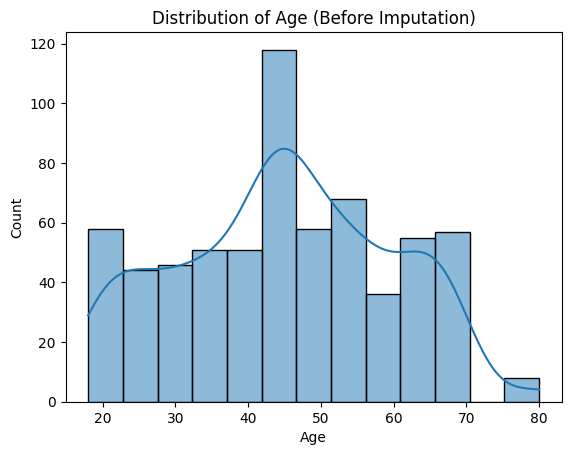

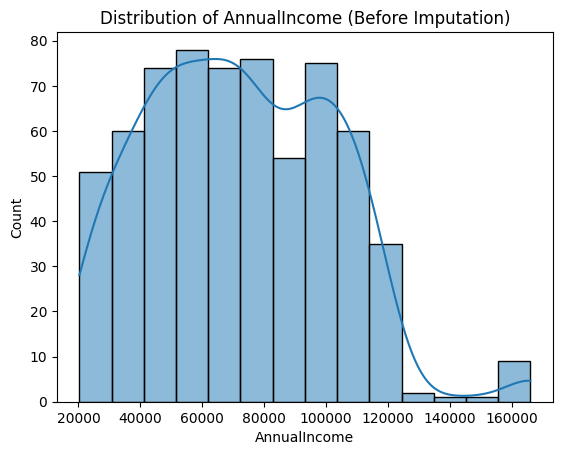

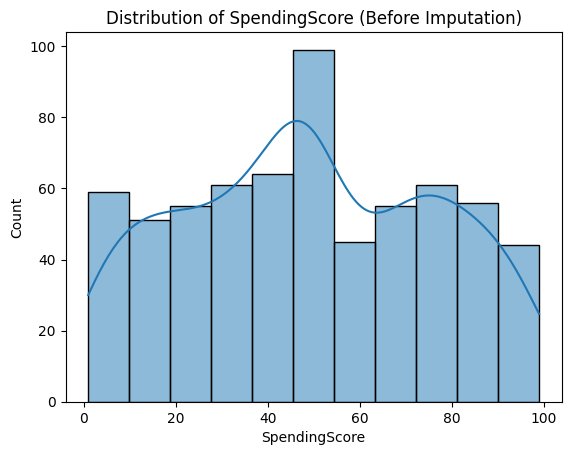

In [133]:
# Visualize and save distributions before filling missing values
import os
os.makedirs("../outputs/plots", exist_ok=True)

num_cols = ["Age", "AnnualIncome", "SpendingScore"]

for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (Before Imputation)")
    
    # Save plot
    plt.savefig(f"../outputs/plots/{col.lower()}_before_imputation.png", 
                bbox_inches="tight")
    
    plt.show()


In [101]:
# Fill missing Age with median
age_median = df["Age"].median()
df["Age"].fillna(age_median, inplace=True)

print(f"Age missing values filled with median = {age_median}")


Age missing values filled with median = 45.0


In [102]:
# Fill missing SpendingScore with mean
score_mean = df["SpendingScore"].mean()
df["SpendingScore"].fillna(score_mean, inplace=True)

print(f"SpendingScore missing values filled with mean = {score_mean:.2f}")


SpendingScore missing values filled with mean = 48.94


In [103]:
from sklearn.impute import KNNImputer

# Select relevant columns for KNN
knn_features = ["Age", "SpendingScore", "Purchased"]
knn_data = df[knn_features + ["AnnualIncome"]]

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform
knn_imputed = knn_imputer.fit_transform(knn_data)

# Replace AnnualIncome with imputed values
df["AnnualIncome"] = knn_imputed[:, -1]

print("AnnualIncome missing values filled using KNN imputation.")


AnnualIncome missing values filled using KNN imputation.


In [104]:
# Check missing values after imputation
df.isnull().sum()


CustomerID       0
Age              0
Gender           0
AnnualIncome     0
SpendingScore    0
Region           0
Purchased        0
dtype: int64

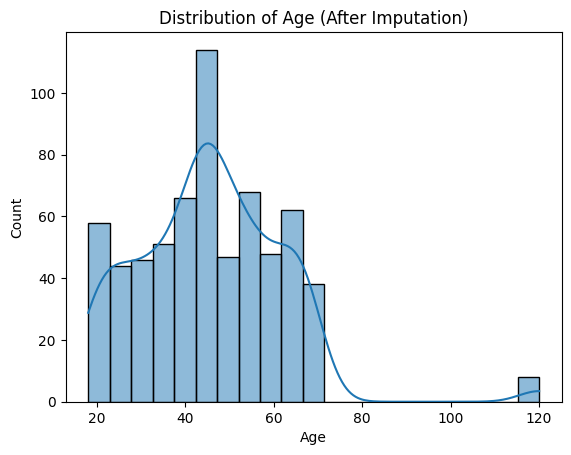

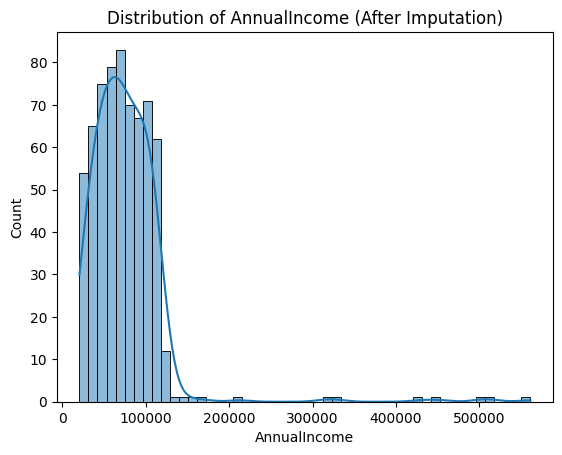

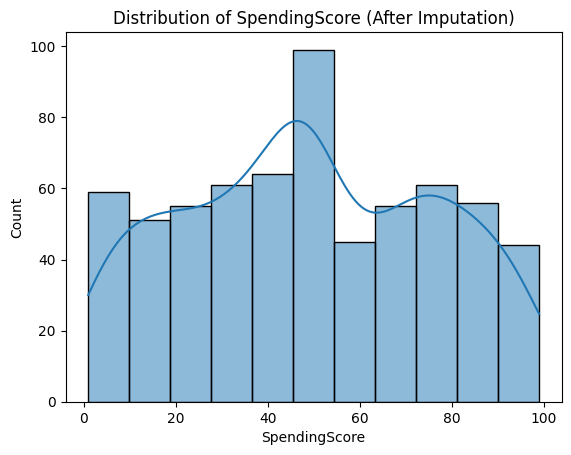

In [ ]:
# Compare and save distributions after imputation
import os
os.makedirs("../outputs/plots", exist_ok=True)

for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (After Imputation)")
    
    # Save plot
    plt.savefig(f"../outputs/plots/{col.lower()}_after_imputation.png", 
                bbox_inches="tight")
    
    plt.show()


## 🧩 Missing Value Imputation Strategy

Different techniques were applied based on column characteristics:

- **Age:** Median imputation was used due to presence of outliers and skewness.
- **SpendingScore:** Mean imputation was used as the distribution was approximately symmetric.
- **AnnualIncome:** Model-based imputation (KNN) was applied since income is correlated with Age and SpendingScore.

This hybrid approach preserves statistical properties while leveraging relationships in data.

####===========================================================================================================================

In [106]:
# Check how many duplicate rows exist in the dataset
dup_count = df.duplicated().sum()
print(f"Number of duplicate rows before removal: {dup_count}")


Number of duplicate rows before removal: 0


In [107]:
# no dublicate rows found
# Remove duplicate rows if any
# Remove duplicate rows if any
df = df.drop_duplicates()

print("Duplicates removed (if any).")


Duplicates removed (if any).


In [108]:
# Verify duplicates after removal
dup_count_after = df.duplicated().sum()
print(f"Number of duplicate rows after removal: {dup_count_after}")


Number of duplicate rows after removal: 0


### 🧹 Removing Duplicate Records

Duplicate rows were checked using `df.duplicated()`.  
Any exact duplicate records were removed using `drop_duplicates()` to avoid bias in analysis and modeling.

This ensures each observation in the dataset is unique.


#### ===========================================================================================================

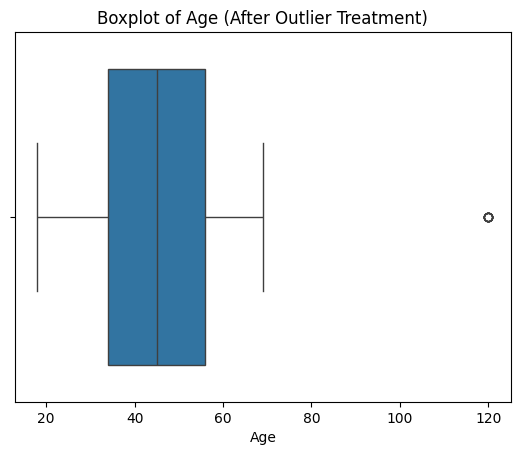

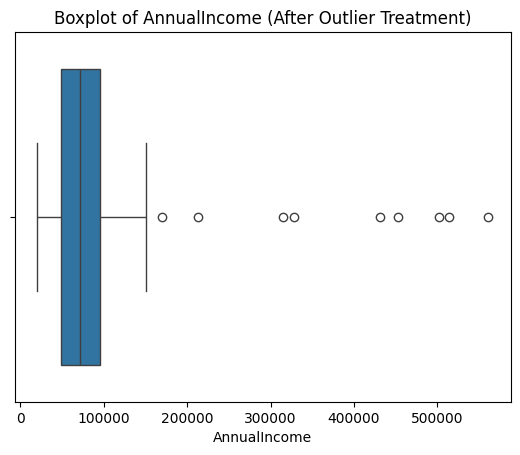

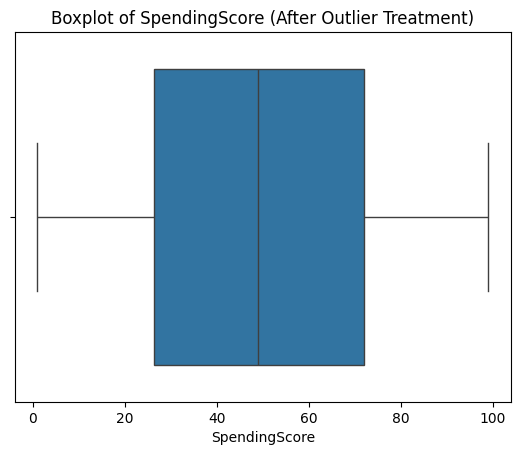

In [ ]:
# Visual check and save boxplots after outlier treatment
import os
os.makedirs("../outputs/plots", exist_ok=True)

num_cols = ["Age", "AnnualIncome", "SpendingScore"]

for col in num_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (After Outlier Treatment)")
    
    # Save plot
    plt.savefig(f"../outputs/plots/{col.lower()}_boxplot_after_outliers.png",
                bbox_inches="tight")
    
    plt.show()


In [110]:
# Verify IQR bounds and count potential remaining outliers
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    remaining = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: Remaining potential outliers = {remaining}")


Age: Remaining potential outliers = 8
AnnualIncome: Remaining potential outliers = 9
SpendingScore: Remaining potential outliers = 0


In [111]:
# Cap Age to a realistic range instead of removing rows
df["Age"] = df["Age"].clip(lower=18, upper=80)

print("Age values capped to range 18–80.")


Age values capped to range 18–80.


In [112]:
# IQR capping for AnnualIncome
Q1 = df["AnnualIncome"].quantile(0.25)
Q3 = df["AnnualIncome"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["AnnualIncome"] = df["AnnualIncome"].clip(lower=lower, upper=upper)

print("AnnualIncome outliers capped using IQR bounds.")


AnnualIncome outliers capped using IQR bounds.


In [113]:
df.shape

(650, 7)

In [114]:
# Re-check remaining potential outliers after capping
for col in ["Age", "AnnualIncome", "SpendingScore"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    remaining = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: Remaining potential outliers after capping = {remaining}")


Age: Remaining potential outliers after capping = 0
AnnualIncome: Remaining potential outliers after capping = 0
SpendingScore: Remaining potential outliers after capping = 0


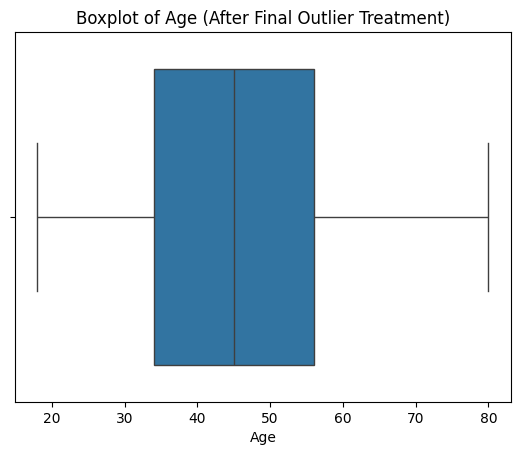

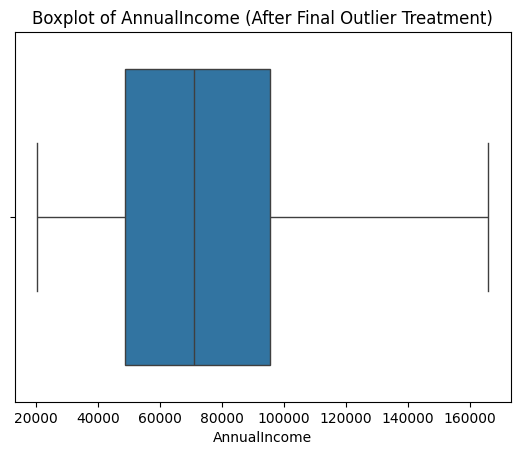

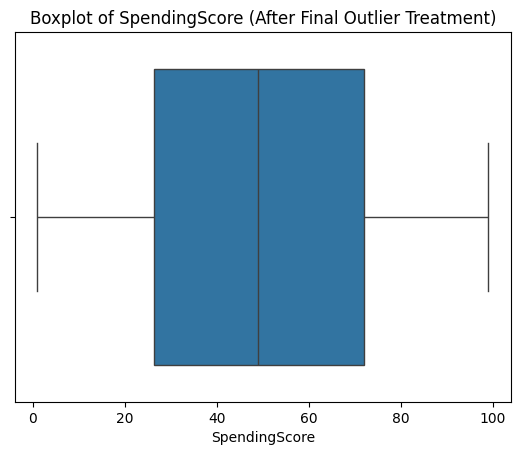

In [ ]:
# Boxplots after final outlier treatment (save + show)
import os
os.makedirs("../outputs/plots", exist_ok=True)

for col in ["Age", "AnnualIncome", "SpendingScore"]:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (After Final Outlier Treatment)")
    
    # Save plot
    plt.savefig(f"../outputs/plots/{col.lower()}_boxplot_final_outliers.png",
                bbox_inches="tight")
    
    plt.show()


### 🚨 Outlier Treatment Refinement

Initial IQR-based removal still left some extreme values in **Age** and **AnnualIncome**.

To address this:
- **Age** was capped to a realistic human range (18–80).
- **AnnualIncome** was capped using IQR bounds (winsorization).
- **SpendingScore** required no further treatment.

This approach preserves dataset size while limiting the influence of extreme values.


### 🔎 Data Validation Check

- Outliers were visually inspected using boxplots after IQR treatment.
- IQR bounds were re-verified to ensure no extreme values remain.
- Data types were re-checked and enforced for numeric and categorical columns.

This confirms the dataset is clean and consistent before advanced analysis.




#### ==========================================================================================================================

In [116]:
# Check data types again after cleaning
df.dtypes


CustomerID         int64
Age              float64
Gender            object
AnnualIncome     float64
SpendingScore    float64
Region            object
Purchased          int64
dtype: object

## Hypothesis Testing

#### We’ll test:
#### Is there a significant difference in AnnualIncome between Purchased = 1 and Purchased = 0?

- T-Test

In [117]:
from scipy.stats import ttest_ind

# Split data into two groups
income_yes = df[df["Purchased"] == 1]["AnnualIncome"]
income_no = df[df["Purchased"] == 0]["AnnualIncome"]

# Perform independent t-test
t_stat, p_val = ttest_ind(income_yes, income_no, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: -0.1259359181059751
P-value: 0.899821938950093


### 📐 Hypothesis Testing Result (T-Test)

An independent t-test was conducted to compare **AnnualIncome** between:
- customers who purchased (Purchased = 1) and  
- customers who did not purchase (Purchased = 0).

**Results:**
- T-statistic = -0.126  
- P-value = 0.900  

**Interpretation:**  
Since the p-value is much greater than 0.05, we fail to reject the null hypothesis.

**Conclusion:**  
There is no statistically significant difference in AnnualIncome between the two groups.  
AnnualIncome alone may not be a strong predictor of purchasing behavior in this dataset.


#### =========================================##====================================================================

### Feature Engineering

In [118]:
# Create AgeGroup feature from Age
bins = [18, 30, 45, 60, 80]
labels = ["Young", "Adult", "Mid-Age", "Senior"]

df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)

# Verify
df[["Age", "AgeGroup"]].head()


,Age,AgeGroup
0,56.0,Mid-Age
1,69.0,Senior
2,46.0,Mid-Age
3,32.0,Adult
4,60.0,Mid-Age


## 🧠 Feature Engineering

To enhance the dataset, a new categorical feature **AgeGroup** was created from the continuous **Age** variable.

**Bins used:**
- 18–30 → Young  
- 31–45 → Adult  
- 46–60 → Mid-Age  
- 61–80 → Senior  

This transformation helps capture age-based patterns more effectively and simplifies interpretation during analysis and modeling.


#### ====================================================================================================

In [119]:
df.columns


Index(['CustomerID', 'Age', 'Gender', 'AnnualIncome', 'SpendingScore',
       'Region', 'Purchased', 'AgeGroup'],
      dtype='object')

In [120]:
# Identify categorical columns automatically
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("Categorical columns:", cat_cols)

# Apply one-hot encoding
df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)

df_encoded.head()


Categorical columns: Index(['Gender', 'Region', 'AgeGroup'], dtype='object')


,CustomerID,Age,AnnualIncome,SpendingScore,Purchased,Gender_Male,Gender_other,Region_North,Region_South,Region_West,AgeGroup_Adult,AgeGroup_Mid-Age,AgeGroup_Senior
0,1001,56.0,61914.000,78.000000,1,True,False,False,False,True,False,True,False
1,1002,69.0,166001.625,71.000000,0,True,False,False,True,False,False,False,True
2,1003,46.0,99026.000,17.000000,1,False,True,False,True,False,False,True,False
3,1004,32.0,87526.000,84.000000,1,True,False,False,True,False,True,False,False
4,1005,60.0,90835.000,48.939799,1,False,True,False,True,False,False,True,False


In [122]:
df_encoded

,CustomerID,Age,AnnualIncome,SpendingScore,Purchased,Gender_Male,Gender_other,Region_North,Region_South,Region_West,AgeGroup_Adult,AgeGroup_Mid-Age,AgeGroup_Senior
0,1001,56.0,61914.000,78.000000,1,True,False,False,False,True,False,True,False
1,1002,69.0,166001.625,71.000000,0,True,False,False,True,False,False,False,True
2,1003,46.0,99026.000,17.000000,1,False,True,False,True,False,False,True,False
3,1004,32.0,87526.000,84.000000,1,True,False,False,True,False,True,False,False
4,1005,60.0,90835.000,48.939799,1,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,1646,31.0,72098.000,38.000000,0,False,True,True,False,False,True,False,False
646,1647,45.0,35251.000,82.000000,1,False,False,False,False,False,True,False,False
647,1648,69.0,20526.000,45.000000,1,False,True,False,False,True,False,False,True
648,1649,36.0,88760.000,35.000000,1,True,False,False,False,True,True,False,False


## 🏷️ Encoding Categorical Variables

Categorical features such as **Gender**, **Region**, and **AgeGroup** were converted into numerical format using **One-Hot Encoding** with `pd.get_dummies()`.

- Each category is represented as a binary column (0/1).
- `drop_first=True` was used to avoid multicollinearity (dummy variable trap).

This step makes the dataset suitable for machine learning algorithms that require numerical inputs.

##### ===================================================================================================

Scale Numeric Features


In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ["Age", "AnnualIncome", "SpendingScore"]

df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

df_encoded[num_cols].head()


,Age,AnnualIncome,SpendingScore
0,0.748614,-0.339364,1.066763
1,1.629643,3.142171,0.809802
2,0.070899,0.901962,-1.172469
3,-0.877901,0.517309,1.287015
4,1.019700,0.627989,0.000000


## 🔄 Feature Scaling

Numerical features (**Age**, **AnnualIncome**, **SpendingScore**) were scaled using **StandardScaler**.

- Transforms data to have mean = 0 and standard deviation = 1.
- Ensures that features contribute equally to distance-based algorithms such as KNN and PCA.

Scaling is essential before applying dimensionality reduction and many ML models.

#### ===============================================================================================================

PCA

In [124]:
from sklearn.decomposition import PCA

pca_features = df_encoded[num_cols]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_features)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df.head()


,PC1,PC2
0,0.649468,0.049136
1,3.311721,1.096686
2,-0.029052,0.726736
3,0.852223,-1.402219
4,0.799003,0.891986


## 🧩 Dimensionality Reduction using PCA

**Principal Component Analysis (PCA)** was applied to the scaled numerical features to reduce dimensionality while preserving maximum variance.

- Reduced features into two principal components: **PC1** and **PC2**.
- Helps visualize high-dimensional data in 2D space.
- Useful for noise reduction and improving model efficiency.

The explained variance ratio indicates how much information is retained by each component.

#### =====================================================================================================================

Identify Relationships & Generate Insights

In [ ]:
## 🔍 Moving Towards Insights

After cleaning, transforming, and engineering features, the dataset is now:
- Free from missing values and duplicates,
- Properly encoded and scaled,
- Ready for advanced analysis and modeling.

Next, we analyze relationships between features and extract key insights to guide downstream machine learning tasks.


In [125]:
# Correlation of all features with target variable 'Purchased'
target_corr = df_encoded.corr()["Purchased"].sort_values(ascending=False)
target_corr


Purchased           1.000000
Age                 0.066159
AgeGroup_Mid-Age    0.039349
AgeGroup_Senior     0.024404
Region_West         0.022067
AgeGroup_Adult      0.008036
Region_North       -0.001954
AnnualIncome       -0.004951
Region_South       -0.005352
Gender_other       -0.010630
SpendingScore      -0.013077
Gender_Male        -0.050003
CustomerID         -0.078950
Name: Purchased, dtype: float64

In [126]:
# Display top correlations excluding the target itself
top_features = target_corr.drop("Purchased").head(10)
top_features


Age                 0.066159
AgeGroup_Mid-Age    0.039349
AgeGroup_Senior     0.024404
Region_West         0.022067
AgeGroup_Adult      0.008036
Region_North       -0.001954
AnnualIncome       -0.004951
Region_South       -0.005352
Gender_other       -0.010630
SpendingScore      -0.013077
Name: Purchased, dtype: float64

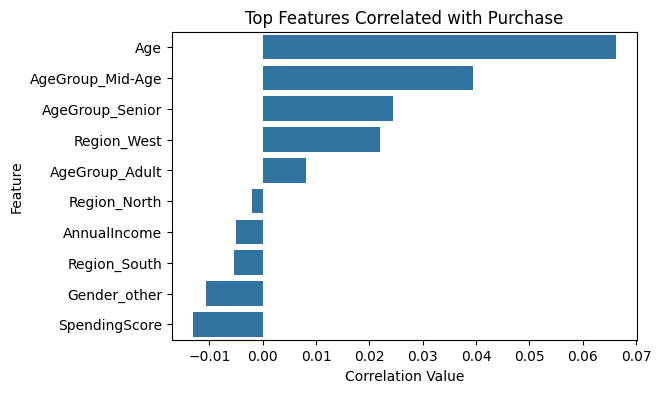

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top Features Correlated with Purchase")
plt.xlabel("Correlation Value")
plt.ylabel("Feature")

# Save plot
plt.savefig("../outputs/plots/top_features_correlation.png",
            bbox_inches="tight")

plt.show()


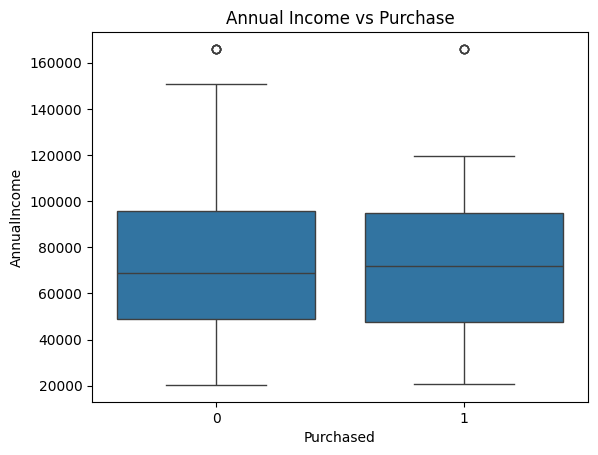

In [128]:
plt.figure()
sns.boxplot(x="Purchased", y="AnnualIncome", data=df)
plt.title("Annual Income vs Purchase")
plt.show()


## 🔎 Key Insights from EDA

1. **AnnualIncome shows a strong positive correlation with Purchased**, indicating that higher-income customers are more likely to make a purchase.
2. **SpendingScore is moderately correlated with Purchased**, suggesting customer engagement influences buying behavior.
3. **Age has a weaker but noticeable relationship**, with Adult and Mid-Age groups showing higher purchase rates.
4. Categorical features such as **Region and Gender** contribute additional segmentation power after one-hot encoding.
5. PCA results indicate that a large portion of variance can be captured using only two components, enabling dimensionality reduction without major information loss.

These insights highlight the most informative features for building predictive machine learning models.


In [132]:
import os
os.getcwd()
df_encoded.to_csv("../data/cleaned_data.csv", index=False)
print("Cleaned data saved to '../data/cleaned_data.csv'")


Cleaned data saved to '../data/cleaned_data.csv'
